[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W1D5_ClimateModeling/W1D5_Tutorial5.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W1D5_ClimateModeling/W1D5_Tutorial5.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>


# Bonus Tutorial 5: Vertical Structure of the Atmosphere

**Week 1, Day 5, Introduction to Climate Modeling**

**Content creators:** Jenna Pearson and Brian E. J. Rose

**Content reviewers:** Mujeeb Abdulfatai, Nkongho Ayuketang Arreyndip, Jeffrey N. A. Aryee, Younkap Nina Duplex, Will Gregory, Paul Heubel, Zahra Khodakaramimaghsoud, Peter Ohue, Abel Shibu, Derick Temfack, Yunlong Xu, Peizhen Yang, Ohad Zivan, Chi Zhang

**Content editors:** Abigail Bodner, Paul Heubel, Brodie Pearson,  Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Paul Heubel, Jenna Pearson, Konstantine Tsafatinos, Chi Zhang, Ohad Zivan

**Our 2024 Sponsors:** CMIP, NFDI4Earth


# Tutorial Objectives

*Estimated timing of tutorial:* 30 minutes

*Note that the previous, the present, and the subsequent tutorials contain solely Bonus content, that serves experienced participants and for later investigation of 0- and 1-dimensional models after the course. Please check out these tutorials after finishing Tutorial 7-8 successfully*.

In this tutorial, you will run a one-dimensional radiative equilibrium model that predicts the global mean atmospheric temperature as a function of height. Much of the code shown here was taken from [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook/home.html) by Brian E. J. Rose. You are encouraged to visit this website for more tutorials and background on these models.

By the end of this tutorial you will be able to:

- Implement a 1-D model that predicts atmospheric temperature as a function of height using the python package `climlab`.
- Understand how this model builds off of the energy balance models developed in the previous tutorials.


# Setup


In [1]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# note the conda install takes quite a while, but conda is REQUIRED to properly download the
# dependencies (that are not just python packages)

# !pip install condacolab &> /dev/null
# import condacolab
# condacolab.install()

# !mamba install -c anaconda cftime xarray numpy &> /dev/null    # for decoding time variables when opening datasets
# !mamba install -c conda-forge metpy climlab &> /dev/null

In [2]:
# imports

# google colab users, if you get an xarray error, please run this cell again

import xarray as xr              # used to manipulate data and open datasets
import numpy as np               # used for algebra/arrays
import climlab                   # one of the models we are using
import matplotlib.pyplot as plt  # used for plotting
import metpy                     # used to make Skew T Plots of temperature and pressure
from metpy.plots import SkewT    # plotting function used widely in climate science
import pooch
import os
import tempfile

/opt/anaconda3/envs/climatematch/lib/python3.9/site-packages/climlab/convection/akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)


In [3]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle"
)

In [4]:
# @title Helper functions


def pooch_load(filelocation=None, filename=None, processor=None):
    # this is different for each day
    shared_location = "/home/jovyan/shared/Data/tutorials/W1D4_ClimateModeling"
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

In [5]:
# @title Video 1: Vertical Structure of the Atmosphere

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
    def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
        self.id = id
        if source == "Bilibili":
            src = f"https://player.bilibili.com/player.html?bvid={id}&page={page}"
        elif source == "Osf":
            src = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render"
        super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
    tab_contents = []
    for i, video_id in enumerate(video_ids):
        out = widgets.Output()
        with out:
            if video_ids[i][0] == "Youtube":
                video = YouTubeVideo(
                    id=video_ids[i][1], width=W, height=H, fs=fs, rel=0
                )
                print(
                    f"Video available at https://youtube.com/watch?v={video.id}")
            else:
                video = PlayVideo(
                    id=video_ids[i][1],
                    source=video_ids[i][0],
                    width=W,
                    height=H,
                    fs=fs,
                    autoplay=False,
                )
                if video_ids[i][0] == "Bilibili":
                    print(
                        f"Video available at https://www.bilibili.com/video/{video.id}"
                    )
                elif video_ids[i][0] == "Osf":
                    print(f"Video available at https://osf.io/{video.id}")
            display(video)
        tab_contents.append(out)
    return tab_contents


video_ids = [("Youtube", "JbNTFVnHvz0"), ("Bilibili", "BV1sz4y1v7hd")]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
    tabs.set_title(i, video_ids[i][0])
display(tabs)

In [6]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "dxthu"

download_link = f"https://osf.io/download/{link_id}/"
render_link = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render"
# @markdown
out = widgets.Output()
with out:
    print(f"If you want to download the slides: {download_link}")
    display(IFrame(src=f"{render_link}", width=730, height=410))
display(out)

Output()

# Section 1: Setting up the Radiative Equilibrium Model Using Climlab


The energy balance model we used earlier today was _zero-dimensional_, yielding only the global mean surface temperature. We might ask, is it possible to construct a similar, _one-dimensional_, model for an _atmospheric column_ to estimate the global mean temperature _profile_ (i.e., including the height/$z$ dimension). Additionally, can we explicitly include the effects of different gases in this model, rather than just parametrizing their collective effects through a single parameter $\tau$? **The answer is yes, we can!**

This model is too complex to construct from scratch, as we did in the previous tutorials. Instead, we will use a model already available within the python package [`climlab`](https://climlab.readthedocs.io/en/latest/intro.html).

The model we will first use is a radiative equilibrium model. **Radiative equilibrium models** consider different layers of the atmosphere. Each of these layers absorbs and emits radiation depending on its constituent gases, allowing the model to calculate the radiation budget for each layer as radiative energy is transferred between atmospheric layers, the Earth's surface, and space. **Radiative equilibrium** is reached when each layer gains energy at the same rate as it loses energy. In this tutorial, you will analyze the temperature profile of this new model once it has reached equilibrium.

To set up this model, we will need information about some of the mean properties of the atmosphere. We are going to download water vapor data from the Community Earth System Model (CESM), a global climate model that we will go into detail on in the next tutorial, to use a variable called [specific humidity](https://glossary.ametsoc.org/wiki/Specific_humidity). **Specific humidity** is the mass of water vapor per mass of a unit block of air. This is useful because water vapor is an important greenhouse gas.


In [7]:
filename_sq = "cpl_1850_f19-Q-gw-only.cam.h0.nc"
url_sq = "https://osf.io/c6q4j/download/"

ds = xr.open_dataset(
    pooch_load(filelocation=url_sq, filename=filename_sq)
)  # ds = dataset
ds

<xarray.Dataset> Size: 345MB
Dimensions:  (time: 240, lev: 26, lat: 96, lon: 144)
Coordinates:
  * lev      (lev) float64 208B 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * time     (time) object 2kB 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    Q        (time, lev, lat, lon) float32 345MB ...
    gw       (lat) float64 768B ...
Attributes: (12/13)
    Conventions:               CF-1.0
    source:                    CAM
    case:                      cpl_1850_f19
    title:                     UNSET
    logname:                   br546577
    host:                      snow-30.rit.alba
    ...                        ...
    revision_Id:               $Id$
    initial_file:              b40.1850.track1.2deg.003.cam.i.0501-01-01-0000...
    topography_file:           /data/rose_scr/cesm_inputdata/atm/cam/topo/USG...
    history:                   Tue Feb 26 17:17:15 2019: ncrcat atm/hist/cpl_...
    NCO:                       4.6.8
    nco_openmp_thread_number:  1

In [8]:
# the specific humidity is stored in a variable called Q
ds.Q

<xarray.DataArray 'Q' (time: 240, lev: 26, lat: 96, lon: 144)> Size: 345MB
[86261760 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 208B 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * time     (time) object 2kB 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

In [9]:
ds.time

<xarray.DataArray 'time' (time: 240)> Size: 2kB
array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(20, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(20, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(21, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2kB 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

However, we want an annual average profile:


In [10]:
# take global, annual average using a weighting (ds.gw) that is calculated based on the model grid - and is similar, but not identical, to a cosine(latitude) weighting

weight_factor = ds.gw / ds.gw.mean(dim="lat")
Qglobal = (ds.Q * weight_factor).mean(dim=("lat", "lon", "time"))
# print specific humidity profile
Qglobal

<xarray.DataArray (lev: 26)> Size: 208B
array([2.16104904e-06, 2.15879387e-06, 2.15121262e-06, 2.13630949e-06,
       2.12163684e-06, 2.11168002e-06, 2.09396914e-06, 2.10589390e-06,
       2.42166155e-06, 3.12595653e-06, 5.01369691e-06, 9.60746488e-06,
       2.08907654e-05, 4.78823747e-05, 1.05492451e-04, 2.11889055e-04,
       3.94176751e-04, 7.10734458e-04, 1.34192099e-03, 2.05153261e-03,
       3.16844784e-03, 4.96883408e-03, 6.62218037e-03, 8.38350326e-03,
       9.38620899e-03, 9.65030544e-03])
Coordinates:
  * lev      (lev) float64 208B 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6

Now that we have a global mean water vapor profile, we can define a model that has the same vertical levels as this water vapor data.


In [11]:
# use 'lev=Qglobal.lev' to create an identical vertical grid to water vapor data
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
mystate

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

To model the absorption and emission of different gases within each atmospheric layer, we use the **[Rapid Radiative Transfer Model](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.RRTMG.html)**, which is contained within the `RRTMG` module. We must first initialize our model using the water vapor.


In [12]:
radmodel = climlab.radiation.RRTMG(
    name="Radiation (all gases)",      # give our model a name
    state=mystate,                     # give our model an initial condition
    specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
    albedo=0.25,                       # set the SURFACE shortwave albedo
    # set the timestep to one day (measured in seconds)
    timestep=climlab.constants.seconds_per_day,
)
radmodel

Let's explore this initial state. Here `Ts` is the initial global mean surface temperature, and `Tatm` is the initial global mean air temperature profile.


In [13]:
radmodel.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

One of the perks of using this model is its ability to incorporate the radiative effects of individual greenhouse gases in different parts of the radiation spectrum, rather than using a bulk reduction in transmission of outgoing longwave radiation (as in our previous models).

Let's display `absorber_vmr`, which contains the **volume mixing ratio**'s of each gas used in the radiative transfer model (these are pre-defined; and do not include the water vapor we used as a model input above). The volume mixing ratio describes the fraction of molecules in the air that are a given gas. For example, $21\%$ of air is oxygen so its volume mixing ratio is $0.21$.


In [14]:
radmodel.absorber_vmr

{'CO2': 0.000348,
 'CH4': 1.65e-06,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CCL4': 0.0,
 'O3': array([7.52507018e-06, 8.51545793e-06, 7.87041289e-06, 5.59601020e-06,
        3.46128454e-06, 2.02820936e-06, 1.13263102e-06, 7.30182697e-07,
        5.27326553e-07, 3.83940962e-07, 2.82227214e-07, 2.12188506e-07,
        1.62569291e-07, 1.17991442e-07, 8.23582543e-08, 6.25738219e-08,
        5.34457156e-08, 4.72688637e-08, 4.23614749e-08, 3.91392482e-08,
        3.56025264e-08, 3.12026770e-08, 2.73165152e-08, 2.47190016e-08,
        2.30518624e-08, 2.22005071e-08])}

To look at carbon dioxide (`"CO2"`) in a more familiar unit, parts per million (by volume), we can convert and print the new value.


In [15]:
radmodel.absorber_vmr["CO2"] * 1e6

348.0

We can also look at all the available diagnostics of our model:


In [16]:
diag_ds = climlab.to_xarray(radmodel.diagnostics)
diag_ds

<xarray.Dataset> Size: 4kB
Dimensions:           (depth: 1, lev: 26, lev_bounds: 27, depth_bounds: 2)
Coordinates:
  * depth             (depth) float64 8B 1.25
  * lev               (lev) float64 208B 3.545 7.389 13.97 ... 929.6 970.6 992.6
  * depth_bounds      (depth_bounds) float64 16B 0.0 2.5
  * lev_bounds        (lev_bounds) float64 216B 0.0 5.467 10.68 ... 981.6 1e+03
Data variables: (12/26)
    OLR               (depth) float64 8B 0.0
    OLRclr            (depth) float64 8B 0.0
    OLRcld            (depth) float64 8B 0.0
    TdotLW            (lev) float64 208B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TdotLW_clr        (lev) float64 208B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    LW_sfc            (depth) float64 8B 0.0
    ...                ...
    SW_flux_up        (lev_bounds) float64 216B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SW_flux_down      (lev_bounds) float64 216B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SW_flux_net       (lev_bounds) float64 216B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SW_flux_up_clr    (lev_bounds) float64 216B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SW_flux_down_clr  (lev_bounds) float64 216B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SW_flux_net_clr   (lev_bounds) float64 216B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

For example to look at $OLR$:

In [17]:
radmodel.OLR

Field([0.])

Note. the $OLR$ is currently 0 as we have not run the model forward in time, so it has not calculated any radiation components.


## Questions 1: Climate Connection


1.  Why do you think all gases, except ozone and water vapor, are represented by single values in the model?


In [18]:
# to_remove explanation

"""
1. The gases aside from ozone and water vapor are all assumed to be well mixed in the atmosphere. This means that we assume they have the same concentration anywhere you measure. However, we know from observations that ozone and water vapor are not well mixed in the atmosphere.
"""

'\n1. The gases aside from ozone and water vapor are all assumed to be well mixed in the atmosphere. This means that we assume they have the same concentration anywhere you measure. However, we know from observations that ozone and water vapor are not well mixed in the atmosphere.\n'

## Coding Exercises 1


1.  On the same graph, plot the annual mean specific humidity profile and ozone profiles.


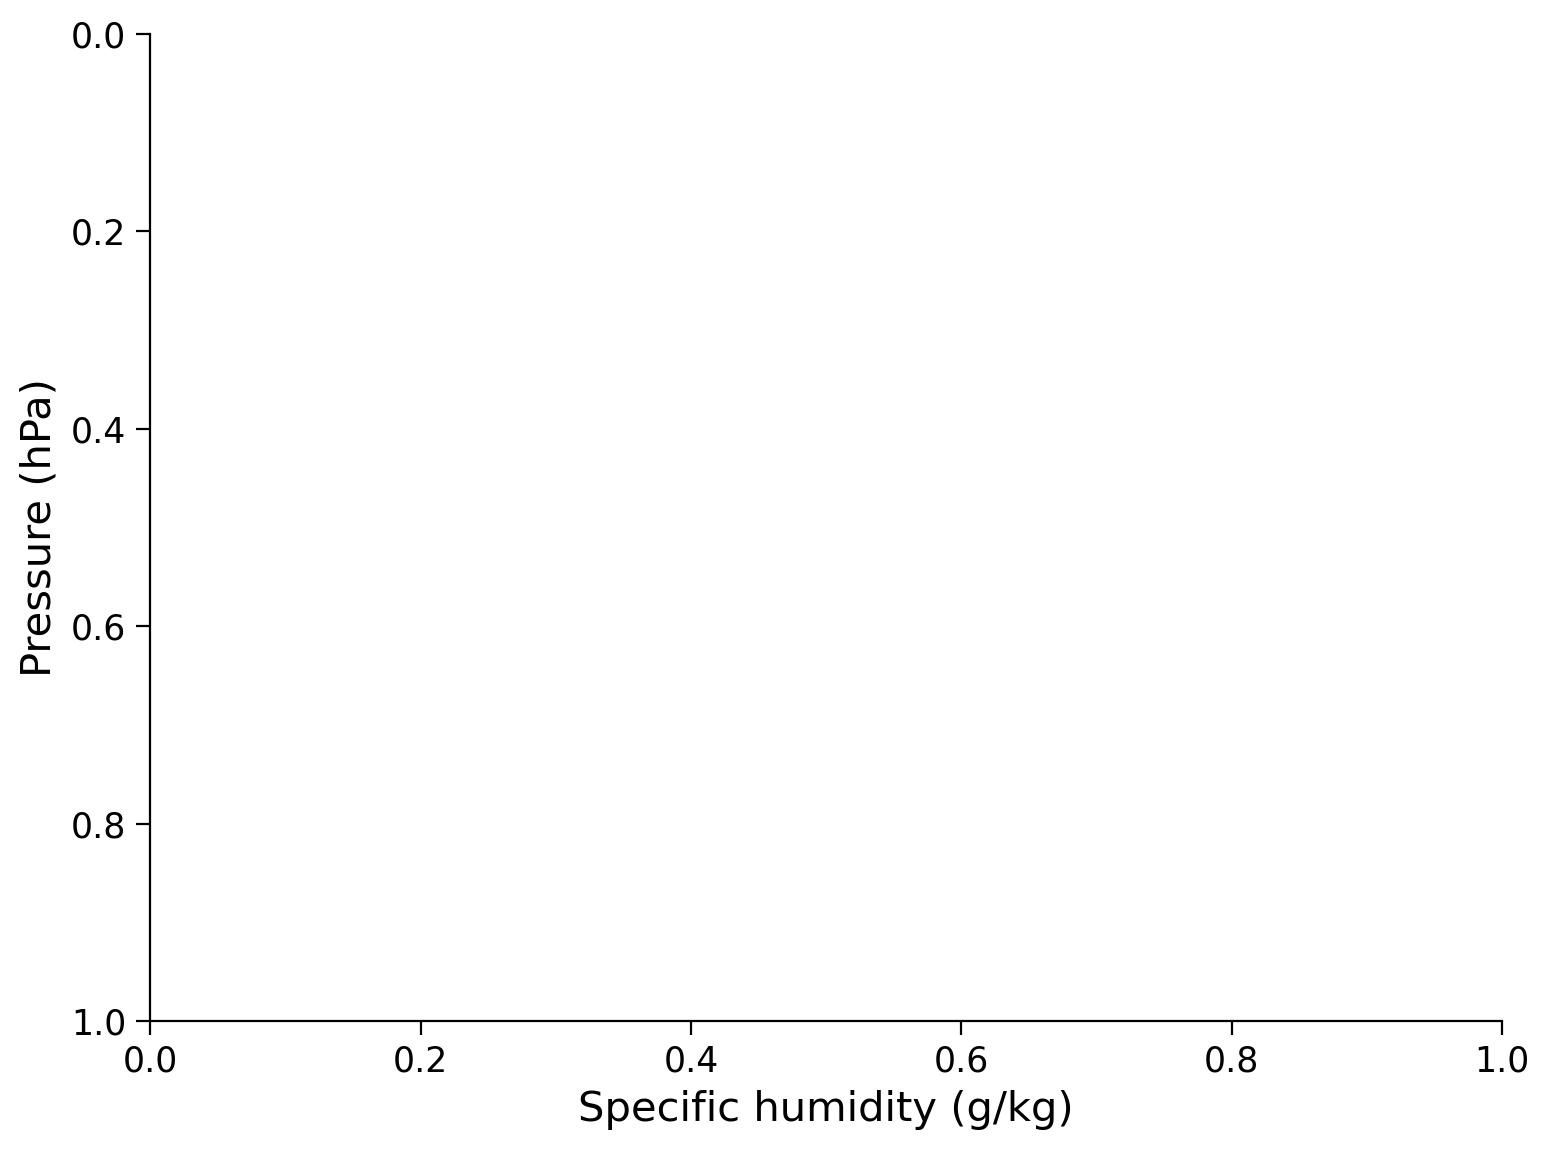

In [19]:
fig, ax = plt.subplots()
# multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
_ = ...
# multiply by 1E6 to get units of ppmv = parts per million by volume
_ = ...

# pressure decreases logarithmically with height in the atmosphere
# invert the axis so the largest value of pressure is lowest
ax.invert_yaxis()
# set y axis to a log scale
_ = ...

ax.set_ylabel("Pressure (hPa)")
ax.set_xlabel("Specific humidity (g/kg)")

# turn on the grid lines
_ = ...

# turn on legend
_ = ...

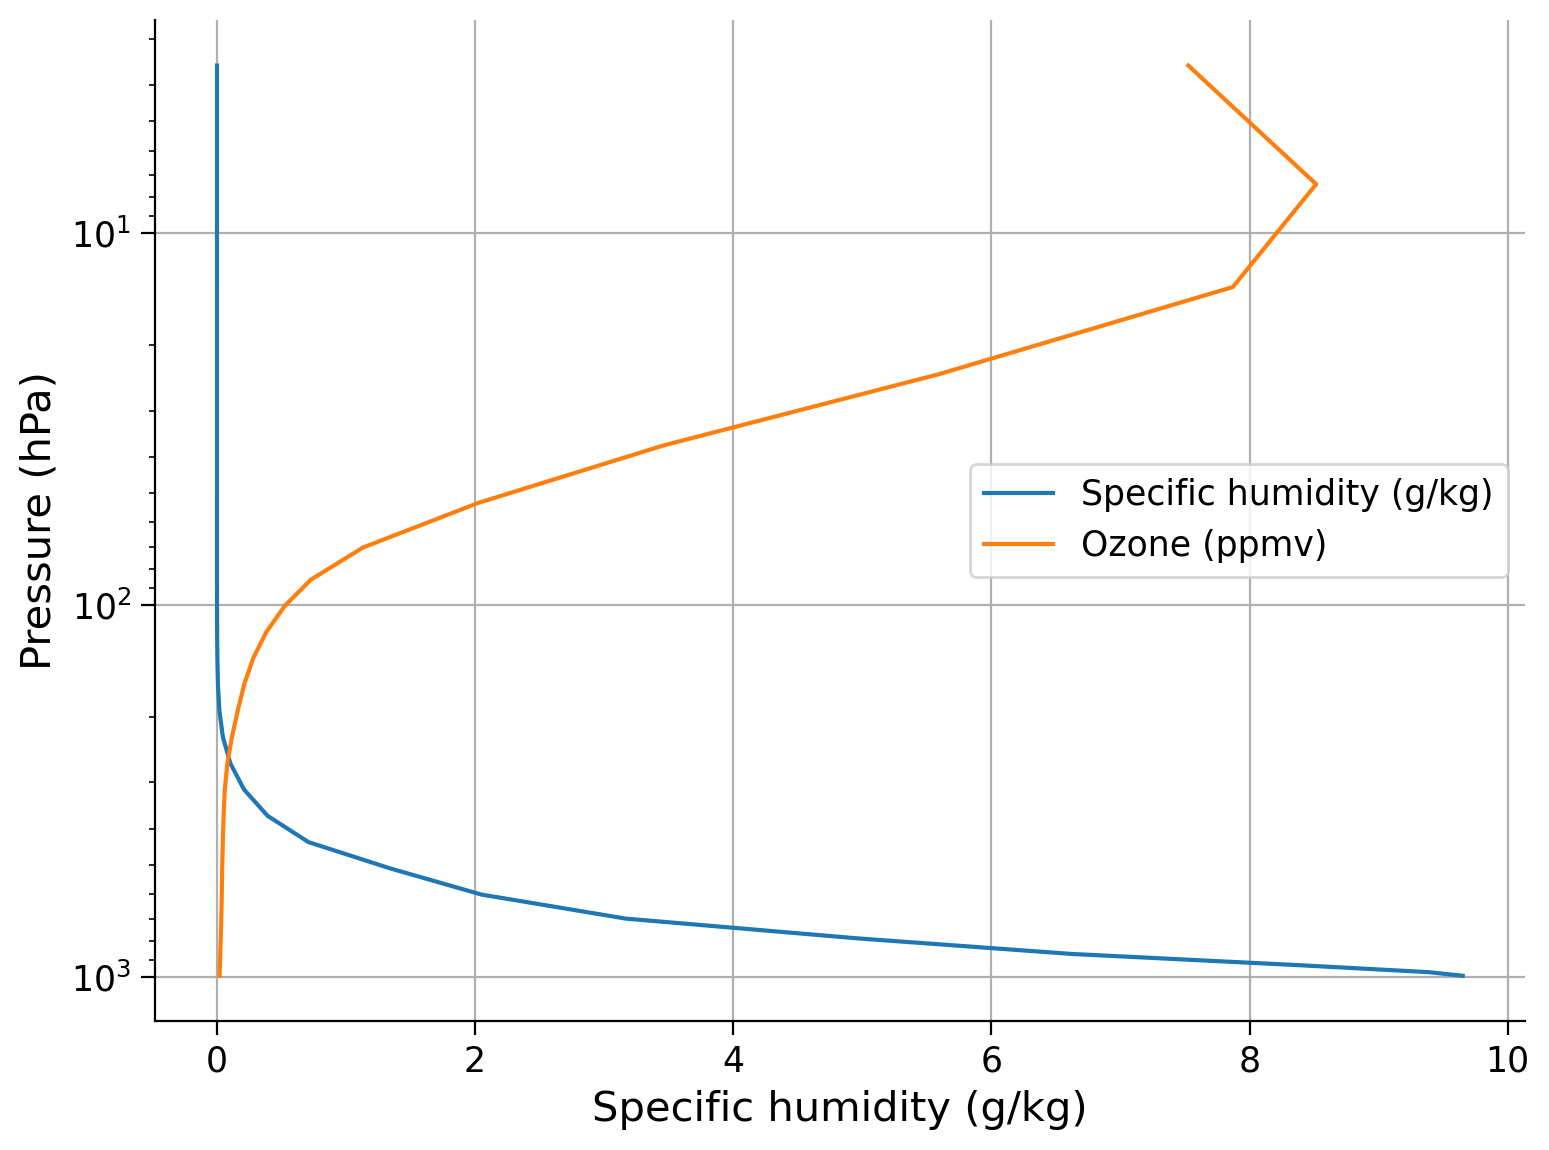

In [20]:
# to_remove solution
fig, ax = plt.subplots()
# multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
_ = ax.plot(Qglobal * 1000.0, Qglobal.lev, label="Specific humidity (g/kg)")
# multiply by 1E6 to get units of ppmv = parts per million by volume
_ = ax.plot(radmodel.absorber_vmr["O3"] * 1e6, radmodel.lev, label="Ozone (ppmv)")

# pressure decreases logarithmically with height in the atmosphere
# invert the axis so the largest value of pressure is lowest
ax.invert_yaxis()
# set y axis to a log scale
_ = ax.set_yscale("log")

ax.set_ylabel("Pressure (hPa)")
ax.set_xlabel("Specific humidity (g/kg)")

# turn on the grid lines
_ = ax.grid()

# turn on legend
_ = ax.legend()

# Section 2: Getting Data to Compare to the Model


Before we run our model forward, we will download a reanalysis product from NCEP to get a sense of what the real global mean atmospheric temperature profile looks like. We will compare this profile to our model runs later.


In [21]:
filename_ncep_air = "air.mon.1981-2010.ltm.nc"
url_ncep_air = "https://osf.io/w6cd5/download/"
ncep_air = xr.open_dataset(
    pooch_load(filelocation=url_ncep_air, filename=filename_ncep_air)
)  # ds = dataset

# this is the long term monthly means (note only 12 time steps)
ncep_air.air

/opt/anaconda3/envs/climatematch/lib/python3.9/site-packages/xarray/coding/times.py:995: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/climatematch/lib/python3.9/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/opt/anaconda3/envs/climatematch/lib/python3.9/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime 

<xarray.DataArray 'air' (time: 12, level: 17, lat: 73, lon: 144)> Size: 9MB
[2144448 values with dtype=float32]
Coordinates:
  * level    (level) float32 68B 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 96B 0001-01-01 00:00:00 ... 0001-12-01 00:00:00
Attributes:
    long_name:     Monthly Long Term Mean of Air temperature
    units:         degC
    precision:     2
    var_desc:      Air Temperature
    level_desc:    Pressure Levels
    statistic:     Long Term Mean
    parent_stat:   Mean
    valid_range:   [-200.  300.]
    actual_range:  [-89.722336  41.616005]
    dataset:       NCEP Reanalysis Derived Products

In [22]:
# need to take the average over space and time
# the grid cells are not the same size moving towards the poles, so we weight by the cosine of latitude to compensate for this
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim="lat")

Tglobal = (ncep_air.air * weight).mean(dim=("lat", "lon", "time"))
Tglobal

<xarray.DataArray (level: 17)> Size: 68B
array([ 15.179084  ,  11.207003  ,   7.8383274 ,   0.21994135,
        -6.4483433 , -14.888848  , -25.570469  , -39.36969   ,
       -46.797905  , -53.652245  , -60.56356   , -67.006065  ,
       -65.53293   , -61.48664   , -55.853584  , -51.593952  ,
       -43.21999   ], dtype=float32)
Coordinates:
  * level    (level) float32 68B 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0

Below we will define two helper funcitons to visualize the profiles output from our model with a _SkewT_ plot. This is common way to plot atmospheric temperature in climate science, and the `metpy` package has a built in function to make this easier.


In [23]:
# to setup the skewT and plot observations
def make_skewT():
    fig = plt.figure(
        figsize=(9, 9)
    )
    skew = SkewT(fig, rotation=30)
    skew.plot(
        Tglobal.level,
        Tglobal,
        color="black",
        linestyle="-",
        linewidth=2,
        label="Observations",
    )
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    # skew.plot_dry_adiabats(linewidth=1.5, label = 'dry adiabats')
    # skew.plot_moist_adiabats(linewidth=1.5, label = 'moist adiabats')
    # skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel("Temperature (degC)"
                       #, fontsize=14
                      )
    skew.ax.set_ylabel("Pressure (hPa)"
                       #, fontsize=14
                      )
    return skew

In [24]:
# to add a model derived profile to the skewT figure
def add_profile(skew, model, linestyle="-", color=None):
    line = skew.plot(
        model.lev,
        model.Tatm - climlab.constants.tempCtoK,
        label=model.name,
        linewidth=2,
    )[0]
    skew.plot(
        1000,
        model.Ts - climlab.constants.tempCtoK,
        "o",
        markersize=8,
        color=line.get_color(),
    )
    skew.ax.legend()

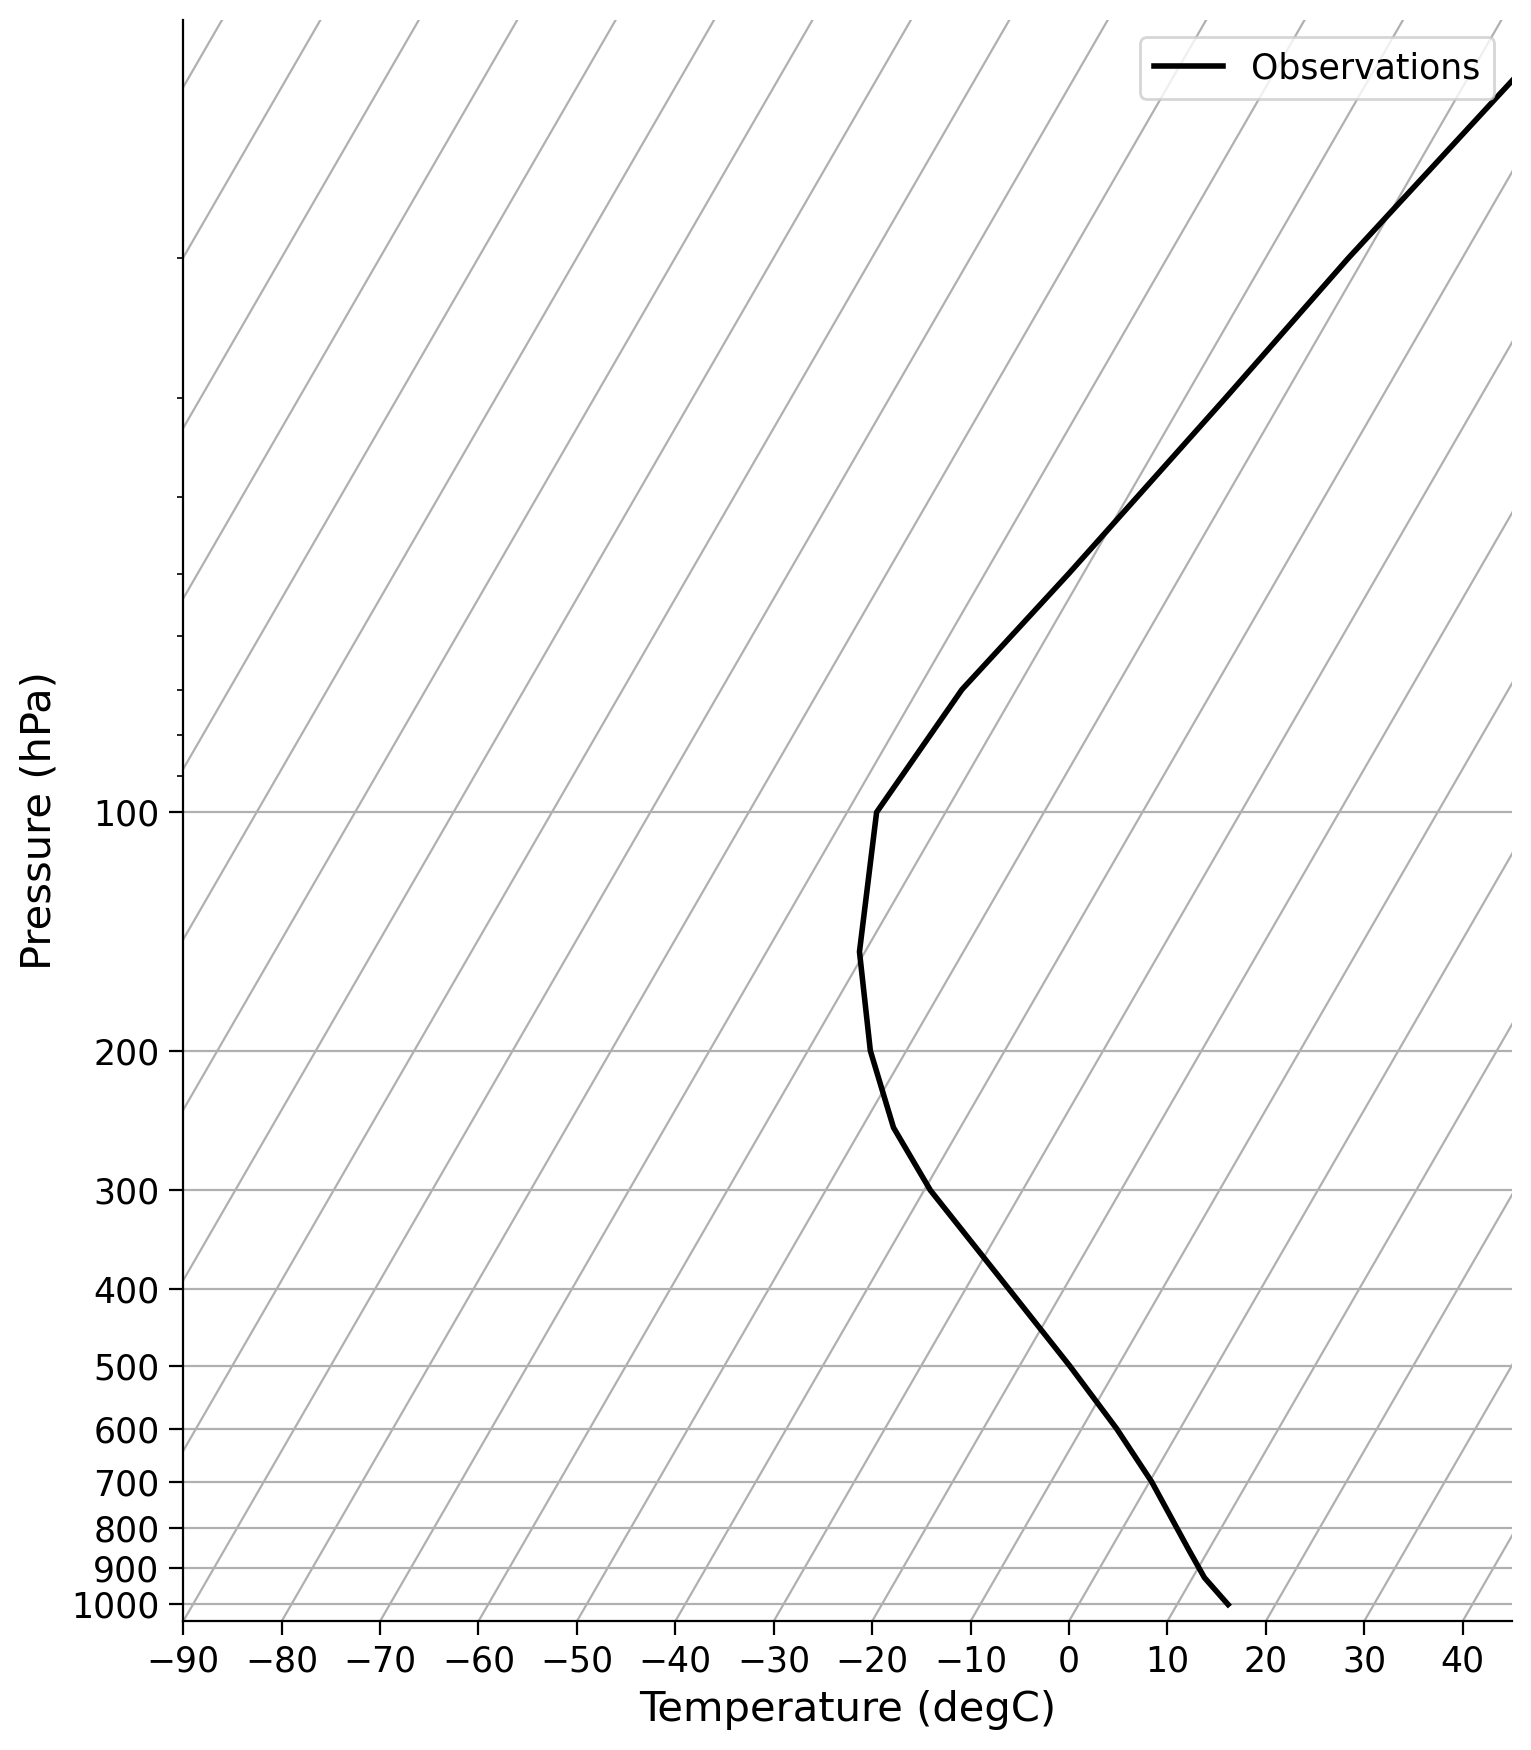

In [25]:
skew = make_skewT()

SkewT (also known as SkewT-logP) plots are generally used for much [more complex reasons](https://www.weather.gov/source/zhu/ZHU_Training_Page/convective_parameters/skewt/skewtinfo.html) than we will use here. However, one of the benefits of this plot that we will utilize is the fact that pressure decreases approximately logarithmically with height. Thus, with a _logP_ axis, we are showing information that is roughly linear in height, making the plots more intuitive.


# Section 3: Running the Radiative Equilibrium Model Forward in Time


We can run this model over many time steps, just like the simple greenhouse model, but now we can examine the behavior of the temperature profile rather than just the surface temperature.

There is no need to write out a function to step our model forward - `climlab` already has this feature. We will use this function to run our model to equilibrium (i.e. until $OLR$ is balanced by $ASR$).


In [26]:
# take a single step forward to the diagnostics are updated and there is some energy imbalance
radmodel.step_forward()

# run the model to equilibrium (the difference between ASR and OLR is a very small number)
while np.abs(radmodel.ASR - radmodel.OLR) > 0.001:
    radmodel.step_forward()

In [27]:
#  check the energy budget to make sure we are really at equilibrium
radmodel.ASR - radmodel.OLR

Field([0.0009879])

Now let's can compare this to observations.


Text(0.5, 1.0, 'Pure Radiative Equilibrium')

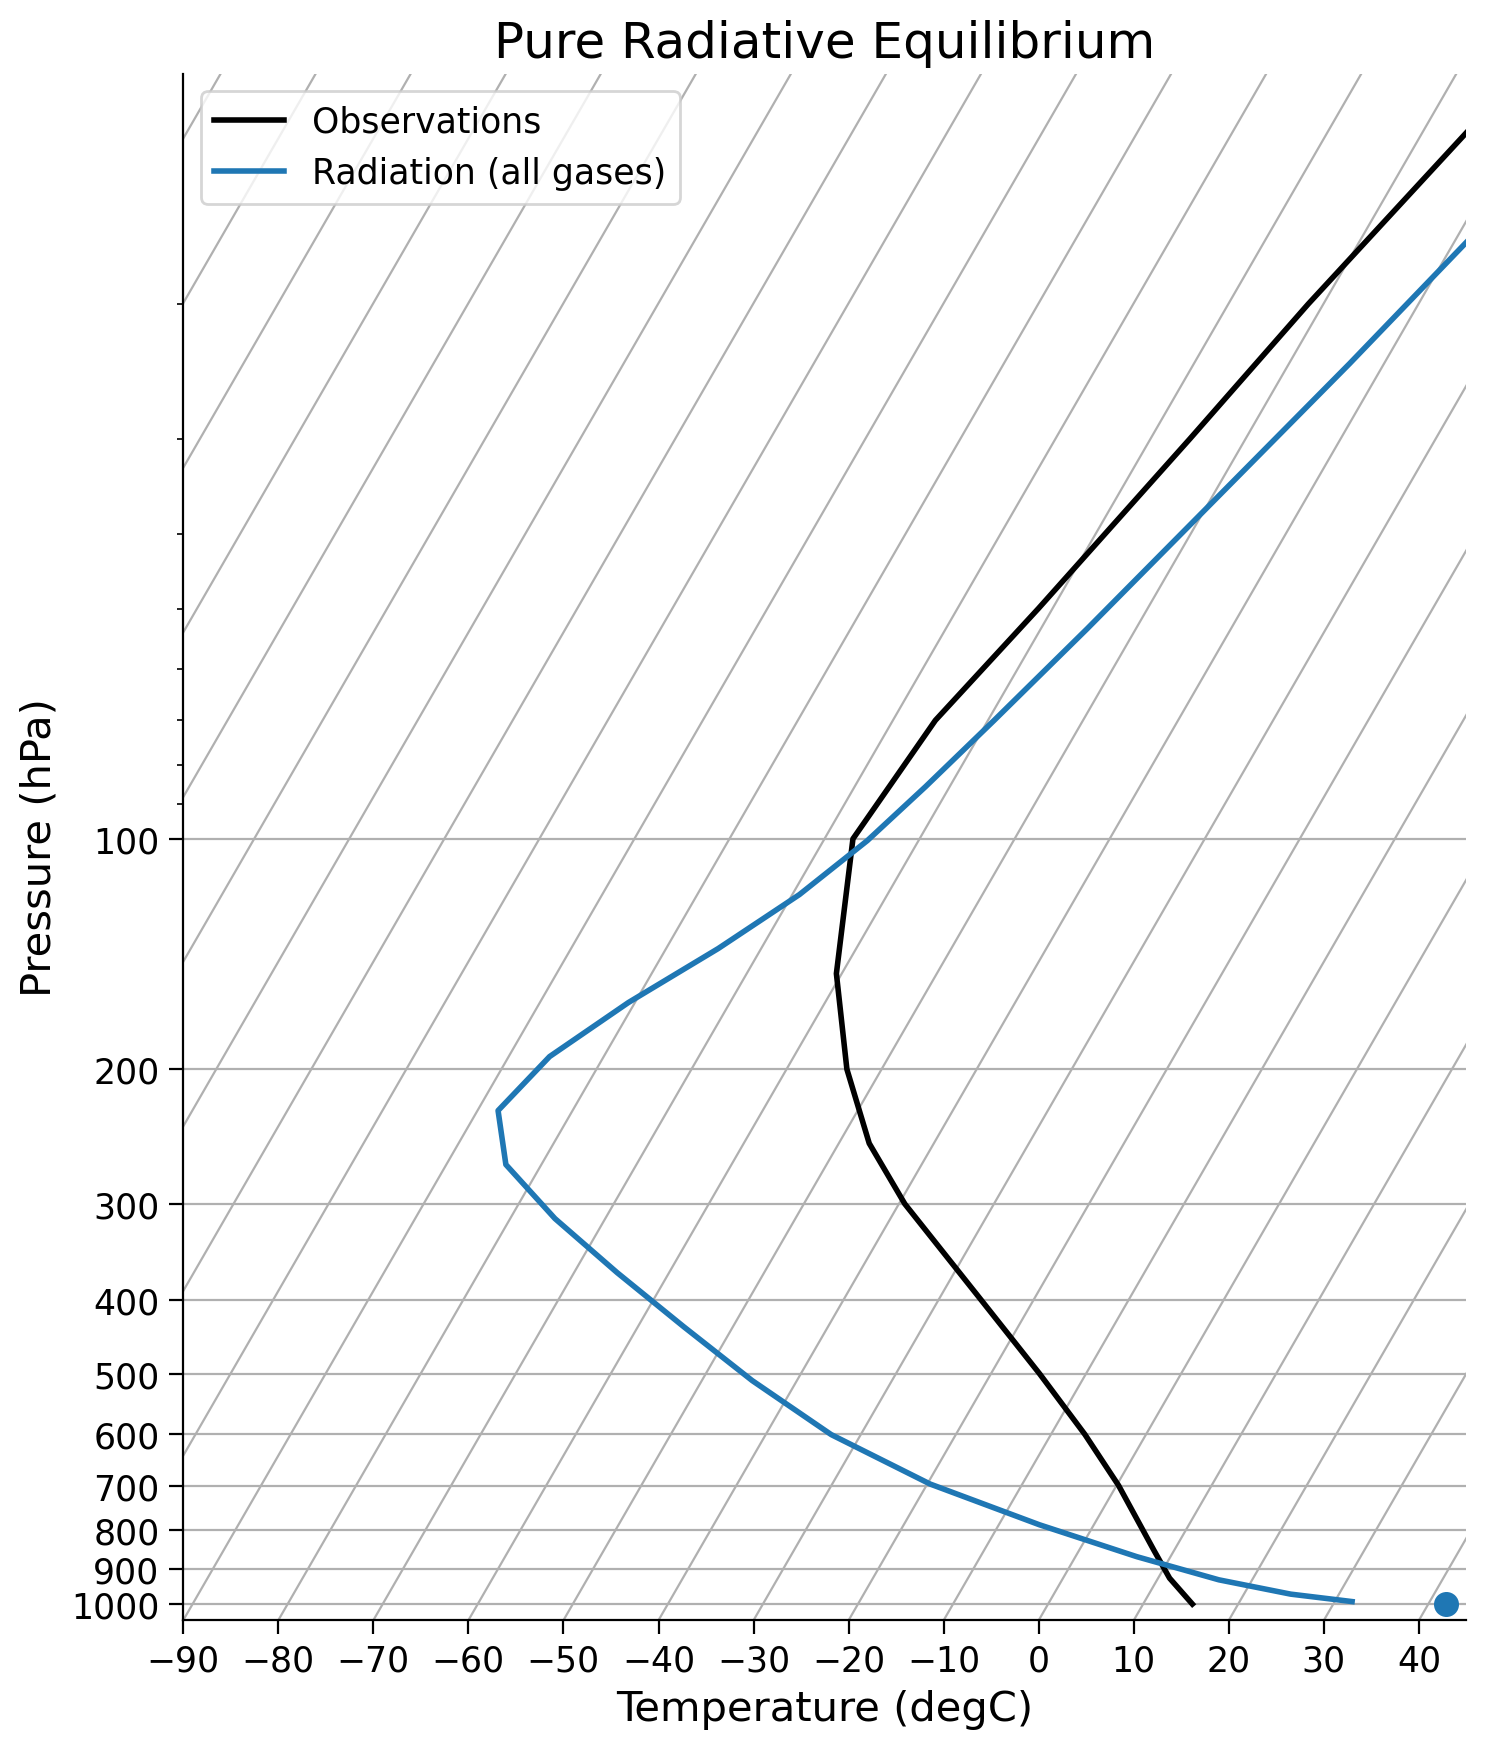

In [28]:
skew = make_skewT()
add_profile(skew, radmodel)
skew.ax.set_title("Pure Radiative Equilibrium")

## Questions 3: Climate Connection


1. The profile from our model does not match observations well. Can you think of one component we might be missing?
2. What effect do you think the individual gases play in determining this profile and why?


In [29]:
# to_remove explanation

"""
1. One thing we are currently lacking is physical processes (aside from radiation) in our model.
2. This is a hard question to answer! Luckily we can remove gases one at a time from our model to study their individual impact. Any ideas you have here can be tested with this model!
"""

'\n1. One thing we are currently lacking is physical processes (aside from radiation) in our model.\n2. This is a hard question to answer! Luckily we can remove gases one at a time from our model to study their individual impact. Any ideas you have here can be tested with this model!\n'

## Coding Exercises 3


1. Create a second model called 'Radiation (no H20)' that lacks water vapor. Then re-create the plot above, but add on this extra profile without water vapor.


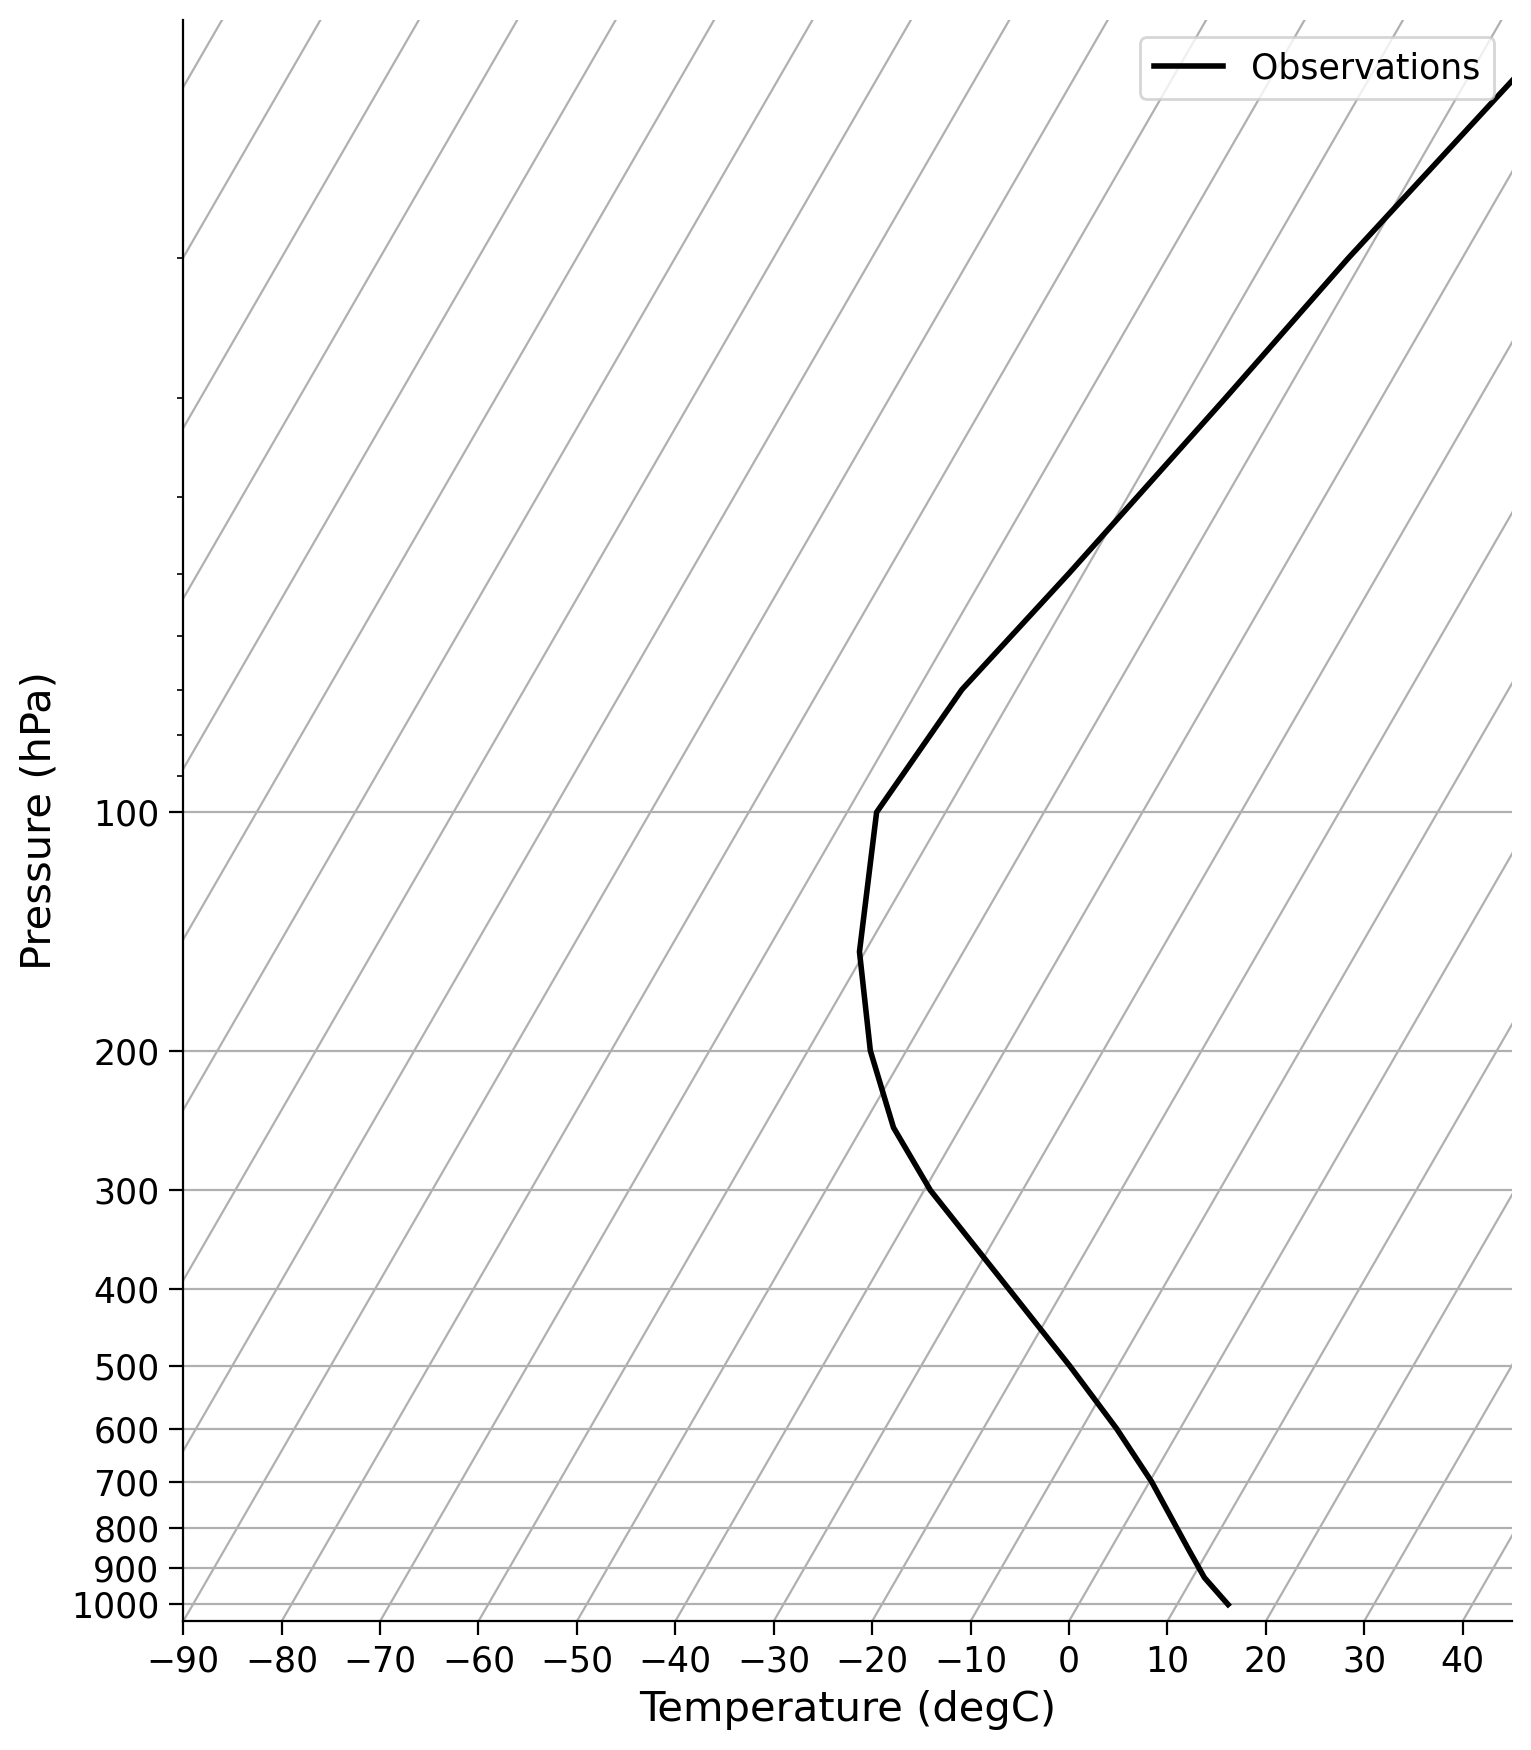

In [30]:
# make an exact clone of our existing model
radmodel_noH2O = climlab.process_like(radmodel)
# change the name of our new model
radmodel_noH2O.name = ...

# set the water vapor profile to all zeros
radmodel_noH2O.specific_humidity *= 0.0

# run the model to equilibrium
radmodel_noH2O.step_forward()
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR) > 0.01:
    radmodel_noH2O.step_forward()

# create skewT plot
skew = make_skewT()

# add profiles for both models to plot
for model in [...]:
    ...

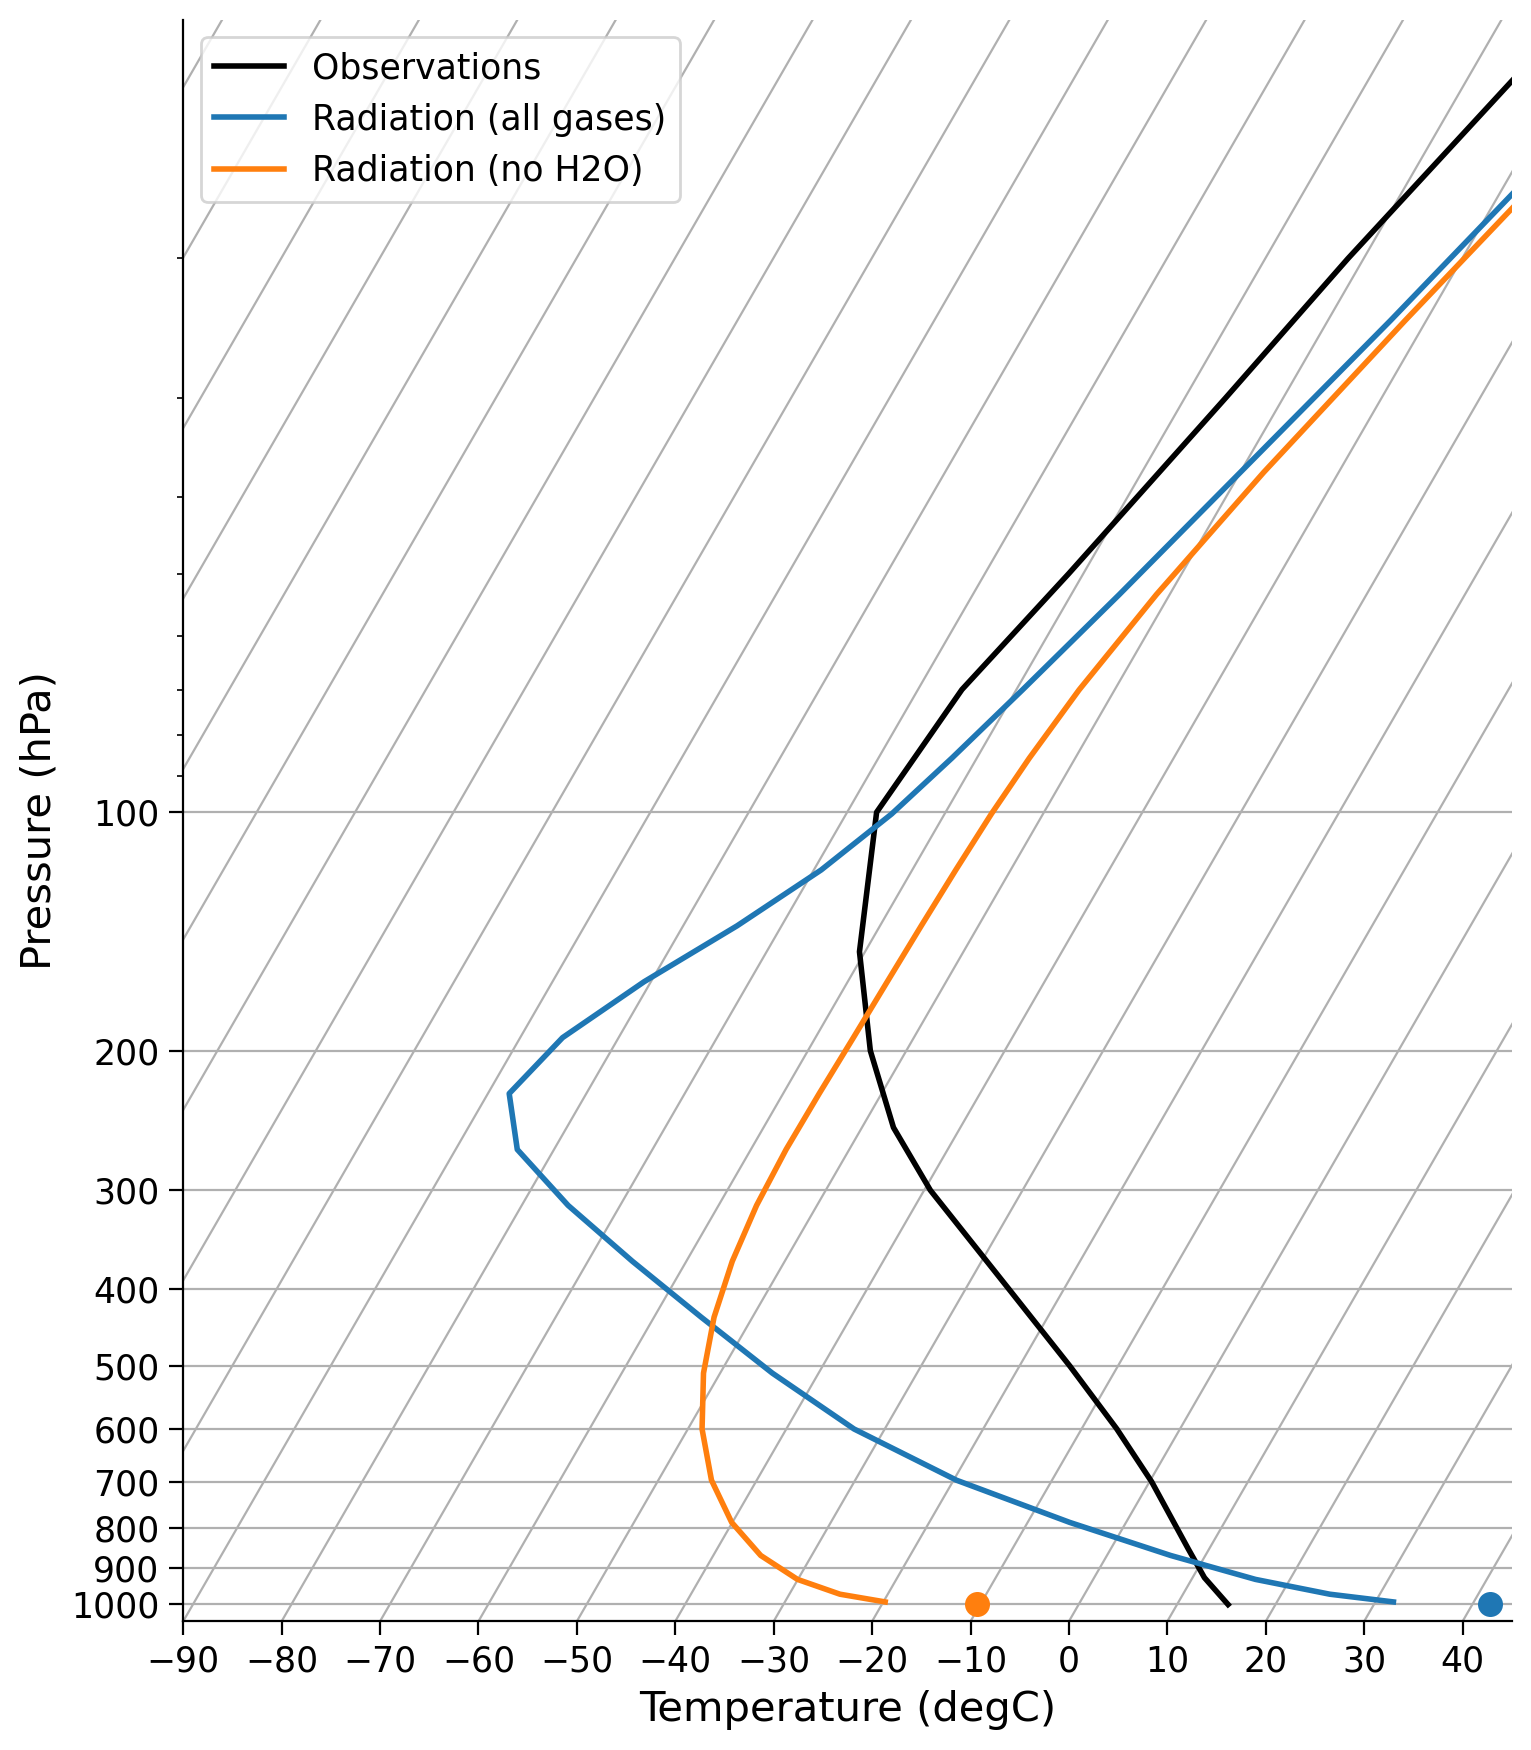

In [31]:
# to_remove solution

# make an exact clone of our existing model
radmodel_noH2O = climlab.process_like(radmodel)
# change the name of our new model
radmodel_noH2O.name = "Radiation (no H2O)"

# set the water vapor profile to all zeros
radmodel_noH2O.specific_humidity *= 0.0

# run the model to equilibrium
radmodel_noH2O.step_forward()
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR) > 0.01:
    radmodel_noH2O.step_forward()

# create skewT plot
skew = make_skewT()

# add profiles for both models to plot
for model in [radmodel, radmodel_noH2O]:
    add_profile(skew, model)

# Summary

In this tutorial, you've learned how to use the python package `climlab` to construct a one-dimensional radiative equilibrium model, and run it forward in time to predict the global mean atmospheric temperature profile. You've also visualized these results through SkewT plots.


# Resources

Data from this tutorial can be accessed for specific humidity [here](http://thredds.atmos.albany.edu:8080/thredds/fileServer/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc) and reanalysis temperature [here](https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/pressure/air.mon.1981-2010.ltm.nc).

Useful links:
- [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook/home.html) by Brian E. J. Rose
- [Specific Humidity](https://glossary.ametsoc.org/wiki/Specific_humidity)
- [Rapid Radiative Transfer Model](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.RRTMG.html)
- [SkewT plots - Advanced Tutorials](https://www.weather.gov/source/zhu/ZHU_Training_Page/convective_parameters/skewt/skewtinfo.html)